In [1]:
'''A script to run UQ for a pipe using PCN.

Parameters
----------

expan_coef: int
size of friction coefficient vector

uni_prior_down: float * expan_coef
lower bound for the uniform prior

uni_prior_up: float * expan_coef
upper bound for the uniform prior

initial_point_mcmc: float * expan_coef
initial point in the MCMC sampler

c_sound: float
sound speed

t_final: float
final time

x_l: float
left boundary of the domain

x_r: float
right boundary of the domain

dx: float
mesh size

boundary_eps: float
a number for computing pressure drop at both ends of the pipe

pipe_true: SemiLinSystem
an object that represents and contains attributes of the true pipe

pipe: SemiLinSystem 
an object that represents and contains attributes
of a pipe used during MCMC for sampling

'''

from UQuant.SemilinearSystem import SemiLinSystem
from bayesianinversion import MCMCBayesianInversion, PCNBayesianInversion
from numpy.random import normal

# build a pipe

## physical settings
c_sound = 1.0
t_final = 5.0
x_l, x_r = [0.0, 1.0]
dx = 0.005
boundary_eps = 0.05

## true friction coefficient
true_friction = [0.185938, -0.0519335, 0., 0., -0.0696583, 0.0336323, 0., 0., \
                 0.0348292, -0.0121076, 0., 0., -0.00773981, 0.00105987, 0., 0., 0., \
                 -0.000641154, 0., 0., -0.00278633, 0.00250158, 0., 0., 0.00386991, \
                 -0.00179107, 0., 0., -0.0014216, 0.000230816, 0., 0., 0., \
                 -0.000179701, 0., 0., -0.000859979, 0.000838478, 0., 0., 0.00139317]

initial_point_mcmc = [0.45, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
uni_prior_range = {
    "up":   [0.5, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
    "down": [0.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05, -.05],
}


true_expan_coef = len(true_friction)

time_ins = 20
time_ins_fine = 100

# construct and run the true pipe
pipe_true = SemiLinSystem(c_sound, t_final, x_l, x_r, dx, true_expan_coef, boundary_eps)
pipe_true.run(true_friction)

y_obs_true = pipe_true.get_presure_drop(time_instance=time_ins_fine, inplace=False)

epsilon = 0.05
y_obs = normal(0.0, epsilon, time_ins_fine) + y_obs_true
y_obs_times = pipe_true.timeslices

Address of the pipe in the memory from python:  0x36d3be0


In [20]:
def PCN_MCMC_thread(data):
    '''
    for full multi-threading: running MCMC and PCN alongside.
    '''
    
    solver_name, expan_coef = data
    
    init_pt = initial_point_mcmc[:expan_coef]
    sigma_normal = 0.05

    conf = {
        "epsilon": epsilon,
        "sigma_normal": sigma_normal,
        "initial_point_mcmc": init_pt,
        "uni_prior_range": uni_prior_range,
    }    
    
    if solver_name == "MCMC":
        method = MCMCBayesianInversion
    elif solver_name == "PCN":
        method = PCNBayesianInversion
    else:
        print ("solver_name not found")
        return None
    
    solver = method(c_sound, t_final, x_l, x_r, dx, expan_coef, boundary_eps, time_ins)
    solver.run(conf, y_obs, y_obs_times, max_iter=2000, burning=500, jupyter=True)
    return (solver_name, {expan_coef: solver.sampler.stats})

In [34]:
import multiprocessing
from numpy import arange

EXPAN_COEF = [(method, expan_coef) for method in ["PCN", "MCMC"] for expan_coef in list(range(1,7,2))]
NUM_THREAD = 20

In [35]:
# solve in parallel
pool = multiprocessing.Pool(NUM_THREAD)
results = pool.map_async(PCN_MCMC_thread, EXPAN_COEF)

pool.close()
pool.join()

Address of the pipe in the memory from python:  0x3648b20
Address of the pipe in the memory from python:  0x3648b20
Address of the pipe in the memory from python:  0x3831df0
Address of the pipe in the memory from python:  0x3831df0
Address of the pipe in the memory from python:  0x3648b20
Address of the pipe in the memory from python:  0x3831df0


In [15]:
from functools import reduce
from itertools import groupby


def reduceByKey(func, iterable):
    """Reduce by key.
    Equivalent to the Spark counterpart
    Inspired by http://stackoverflow.com/q/33648581/554319
    1. Sort by key
    2. Group by key yielding (key, grouper)
    3. For each pair yield (key, reduce(func, last element of each grouper))
    """
    get_first = lambda p: p[0]
    get_second = lambda p: p[1]
    # iterable.groupBy(_._1).map(l => (l._1, l._2.map(_._2).reduce(func)))
    return map(
        lambda l: (l[0], reduce(func, map(get_second, l[1]))),
        groupby(sorted(iterable, key=get_first), get_first)
    )

In [39]:
res = results.get()

In [40]:
# get the results
reduceByKey(lambda x, y: dict(x.items() + y.items()), res)

[('MCMC',
  {1: {'accepted': 149, 'rejected': 1851},
   3: {'accepted': 51, 'rejected': 1949},
   5: {'accepted': 14, 'rejected': 1986}}),
 ('PCN',
  {1: {'accepted': 80, 'rejected': 1920},
   3: {'accepted': 106, 'rejected': 1894},
   5: {'accepted': 76, 'rejected': 1924}})]

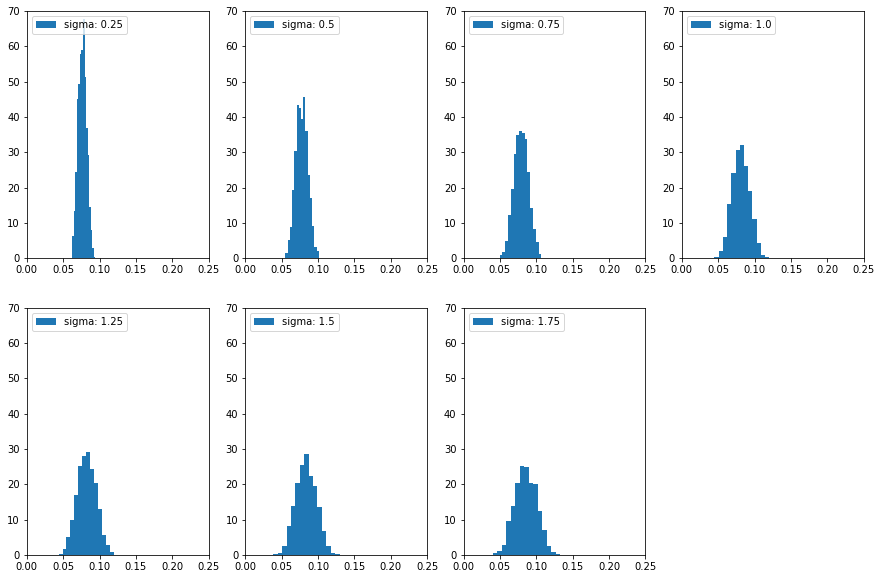

In [10]:
import matplotlib.pyplot as plt

results_list = results.get()
fig = plt.figure(figsize=(15, 10))

for idx, (sigma, result) in enumerate(results_list):
    ax = fig.add_subplot(2, 4, idx+1)
    tmp = ax.hist(result,  normed=True, bins=15, label="sigma: {}".format(sigma))
    ax.set_xlim(0, 0.25)
    ax.set_ylim(0, 70)
    ax.legend(loc='upper left')

In [11]:
fig.savefig("/Home/varioper/hajian/UQ/results/sigma.png")

# Testing